# Autor: Alexej Kravtschenko (100 %)

- **Preface:** Everything is written by me (Alexej). 
This notebook contains everything needed for the useage of an autoencoder with super- and unsupervised learning methods.
It's not fully automated therefore some simple manual work will be needed. Every segment is mostly commented with explanations and instructions. 
- **Dataset:** The UNSW_NB15_training-set dataset was used. This dataset does not contain timestamps.
- **Preprocessing:** The preprocessing does'nt discard any relevant data. Everything of less importance will be summarized into one column for each object "-".
- **Conclusion:** After finishing this notebook the results should reflect a stark contrast between the supervised and unsupervised methods.

## 0. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import random
import json # Used to save the plot history of every model
# Imports for plots and Encoding
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2 # Used for plots
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) # Display max columns without limitation 
pd.set_option('display.max_rows', 500) # Display max rows of 500

In [3]:
# Datapreprocessing
LOG_NUNIQUE = 50 # Applay Log when number of unique values > LOG_NUNIQUE; Default = 50
KEEP_MOST_USED_OBJECTS = 5 # Keep the most used objects per column; Default = 5 -> 3 * 5 Columns kept 

# Training and Evaluation
TRAIN_DATA_FROM_SCRATCH = False # Set to True if you want to train the classification models anew 

In [ ]:
df_train = pd.read_csv('./data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('./data/UNSW_NB15_testing-set.csv')

In [ ]:
df_train = pd.concat([df_train, df_test])

## 1. EDA
The EDA can be skiped.

In [6]:
df_train.shape

(257673, 45)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sinpkt  

In [8]:
df_train.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,254,252,10112.025390,4709.134766,2,1,39.928778,52.241000,2223.730342,82.550500,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
6,7,0.637109,tcp,-,FIN,10,8,534,354,26.683033,254,252,6039.783203,3892.583740,2,1,68.267778,81.137711,4286.828570,119.422719,255,1787309226,1767180493,255,0.143337,0.069136,0.074201,53,44,0,0,43,1,1,1,1,40,0,0,0,1,39,0,Normal,0
7,8,0.521584,tcp,-,FIN,10,8,534,354,32.593026,254,252,7377.527344,4754.747070,2,1,55.794000,66.054141,3770.580726,118.962633,255,205985702,316006300,255,0.116615,0.059195,0.057420,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0
8,9,0.542905,tcp,-,FIN,10,8,534,354,31.313031,254,252,7087.796387,4568.018555,2,1,60.210889,68.109000,4060.625597,106.611547,255,884094874,3410317203,255,0.118584,0.066133,0.052451,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0
9,10,0.258687,tcp,-,FIN,10,6,534,268,57.985135,254,252,14875.120120,6927.291016,2,1,27.505111,39.106801,1413.686415,57.200395,255,3368447996,584859215,255,0.087934,0.063116,0.024818,53,45,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0


In [9]:
df_train.describe(include='all')

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,

In [10]:
# Overview of all the unique features withihn the dataset
mixed_types = df_train.apply(lambda x: any(isinstance(val, str) for val in x))

for column, is_mixed_type in mixed_types.items():
    if is_mixed_type:
        mixed_values = df_train.loc[df_train[column].apply(lambda x: isinstance(x, str)), column].unique()
        print(f"Column '{column}' contains mixed types: {mixed_values}")

Column 'proto' contains mixed types: ['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 'xn

<Axes: xlabel='label', ylabel='Count'>

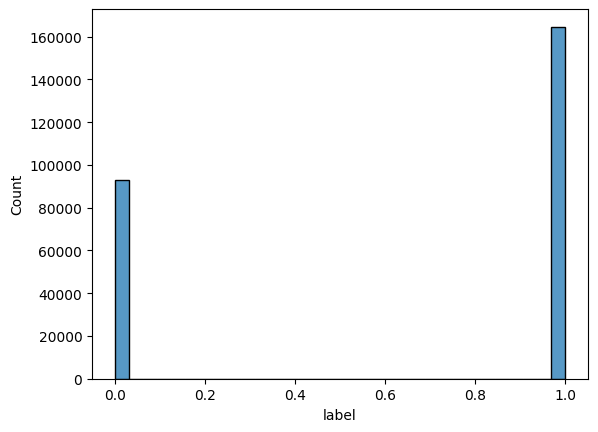

In [11]:
sns.histplot(x = df_train.label)

## 2. Pre-processing 
- The preprocessing is divided into nummeric and categorical features analysis. 
- The goal is a 100% upkeep of the given data without losing any through simple join-operations. Unrelevant features are combined into "-". 
- Losing data resulted in an undesireable result as which was evaluated in "old_main.ipynb"

In [12]:
list_drop = ['id','attack_cat']
df_train.drop(list_drop, axis=1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  dinpkt  

### 2.0 Utility Functions

In [ ]:
def clamp_extreme_values(df):
    """
    Clamp extreme values in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with extreme values clamped.
    """
    df_numeric = df.select_dtypes(include=[np.number])
    for feature in df_numeric.columns:
        if df_numeric[feature].max() > 10 * df_numeric[feature].median() and df_numeric[feature].max() > 10:
            df[feature] = np.where(df[feature] < df[feature].quantile(0.95), 
                                   df[feature], df[feature].quantile(0.95))

    return df

In [ ]:
def apply_log_scaling(df, log_nunique=50):
    """
    Apply log-scaling to selected numeric features in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - log_nunique (int): Threshold for the number of unique values.

    Returns:
    - pd.DataFrame: DataFrame with log-scaled features.
    """

    df_numeric = df.select_dtypes(include=[np.number])

    for feature in df_numeric.columns:
        if df_numeric[feature].nunique() > log_nunique:
            if df_numeric[feature].min() == 0:
                df[feature] = np.log(df[feature] + 1)
            else:
                df[feature] = np.log(df[feature])

    return df

In [ ]:
def keep_most_used_objects(df, keep_threshold=5):
    """
    Keep only the most used objects in categorical features of a DataFrame 
    and combine them into a single row '-'.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - keep_threshold (int): Threshold for the number of unique values to keep.

    Returns:
    - pd.DataFrame: DataFrame with selected categorical features.
    """

    df_cat = df.select_dtypes(exclude=[np.number])

    for feature in df_cat.columns:
        if df_cat[feature].nunique() >= keep_threshold:
            most_used_values = df[feature].value_counts().head().index
            df[feature] = np.where(df[feature].isin(most_used_values), df[feature], '-')

    return df

### 2.1 Nummeric feature analysis

In [13]:
df_numeric_train = df_train.select_dtypes(include=[np.number])
df_numeric_train.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,0.082082,0.036842,0.044665,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,5319.000000,5507.000000,84371.496000,57739.240000,1.483831e+06,463199.240100,255.000000,4.294959e+09,4.294882e+09,255.000000,3.821465,3.226788,2.928778,1504.000000,1500.000000,172.000000,6.558056e+06,63.000000,6.000000,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [17]:
df_clamped_train = clamp_extreme_values(df_train)
df_log_train = apply_log_scaling(df_clamped_train, LOG_NUNIQUE)

### 2.2 Object feature analysis
Since there are many different categorical features, we only need to keep the most used ones 

In [19]:
df_cat_train = df_log_train.select_dtypes(exclude=[np.number])
df_cat_train.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


In [20]:
df_train = keep_most_used_objects(df_log_train, KEEP_MOST_USED_OBJECTS)

In [21]:
df_cat_train = df_train.select_dtypes(exclude=[np.number])
df_cat_train.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,6,5,6
top,tcp,-,FIN
freq,123041,149701,117164


In [22]:
df_train[['proto', 'service', 'state']].value_counts()

proto  service   state
tcp    -         FIN      77905
udp    dns       INT      57692
tcp    http      FIN      26972
udp    -         INT      18607
-      -         INT      18551
unas   -         INT      15599
udp    dns       CON      10675
tcp    smtp      FIN       6844
       ftp-data  FIN       5383
udp    -         CON       5382
arp    -         INT       3695
tcp    -         CON       3170
                 REQ       2511
ospf   -         INT       2294
                 REQ        977
-      -         CON        649
udp    dns       REQ        234
arp    -         CON        151
udp    -         REQ        111
tcp    -         RST         80
       smtp      CON         64
       dns       FIN         60
       http      CON         36
-      -         -           15
tcp    ftp-data  CON          7
       -         -            4
       http      RST          3
       smtp      RST          1
       ftp-data  -            1
Name: count, dtype: int64

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  float64
 5   dpkts              257673 non-null  float64
 6   sbytes             257673 non-null  float64
 7   dbytes             257673 non-null  float64
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  float64
 14  dloss              257673 non-null  float64
 15  sinpkt             257673 non-null  float64
 16  dinpkt  

In [24]:
df_numeric_train = df_train.select_dtypes(include=[np.number])
df_numeric_train.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,0.279701,1.752784,1.367635,6.230272,3.823273,7.719155,180.000931,84.754957,13.782463,5.649463,2.180974,2.956693,1.799721,1.596932,3.564474,2.252746,121.753661,9.906846,9.903646,119.254629,0.041886,0.022283,0.021281,4.486114,2.533020,0.098660,0.327130,9.114517,1.324978,5.658528,4.861627,3.879448,8.051511,0.012819,0.012850,0.098652,6.382822,8.857366,0.014274,0.639077
std,0.404365,1.196432,1.435571,1.474944,3.798091,4.116677,102.488268,112.762131,4.582378,5.659006,3.265256,6.008834,2.091078,2.045817,3.856609,2.719011,127.367443,10.588147,10.586260,127.230477,0.075568,0.044684,0.040134,0.673732,2.479525,0.298205,1.234621,10.058965,0.992300,6.866560,6.864614,5.367192,10.333915,0.116091,0.116421,0.298195,7.084512,10.116552,0.118618,0.480269
min,0.000000,0.000000,0.000000,3.178054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.178054,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,0.693147,0.000000,4.736198,0.000000,3.459129,62.000000,0.000000,9.418898,0.000000,0.000000,0.000000,0.007968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.043051,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.004276,1.386294,1.098612,6.269096,5.187386,7.991817,254.000000,29.000000,13.519720,7.466480,0.000000,0.000000,0.323312,0.006976,0.514999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.290459,3.806662,0.000000,0.000000,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.522227,2.484907,2.397895,7.216709,6.970730,11.736077,254.000000,252.000000,18.197537,10.003622,3.000000,2.000000,4.079142,4.050721,7.933212,4.793415,255.000000,21.420094,21.412782,255.000000,0.078887,0.036180,0.043696,4.605170,4.499810,0.000000,0.000000,12.000000,2.000000,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,1.338000,4.127134,4.143135,9.507032,10.405626,12.716901,255.000000,254.000000,19.401510,15.193128,12.000000,24.000000,5.436469,5.099135,9.162146,7.929434,255.000000,22.067684,22.065875,255.000000,1.573078,1.441442,1.368328,6.458338,6.646910,1.000000,5.075174,34.000000,6.000000,25.000000,25.000000,17.000000,34.000000,4.000000,4.000000,1.000000,25.000000,34.000000,1.000000,1.000000


### 2.3 Overview of the features

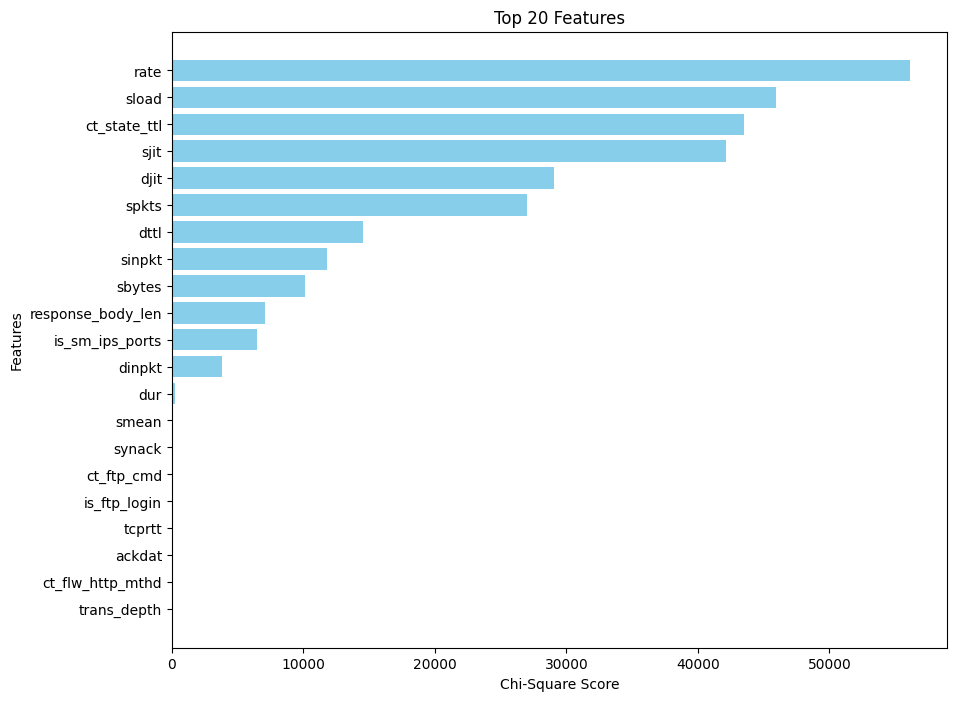

In [25]:
best_features = SelectKBest(score_func=chi2, k='all')

X = df_numeric_train.iloc[:, :-1]
y = df_numeric_train.iloc[:, -1] 
fit = best_features.fit(X, y)

df_scores = pd.DataFrame(fit.scores_)
df_col = pd.DataFrame(X.columns)

feature_score = pd.concat([df_col, df_scores], axis=1)
feature_score.columns = ['feature', 'score']
feature_score.sort_values(by=['score'], ascending=True, inplace=True)

top_20_features = feature_score[0:21]

plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['score'], color='skyblue')
plt.title('Top 20 Features')
plt.xlabel('Chi-Square Score')
plt.ylabel('Features')
plt.show()

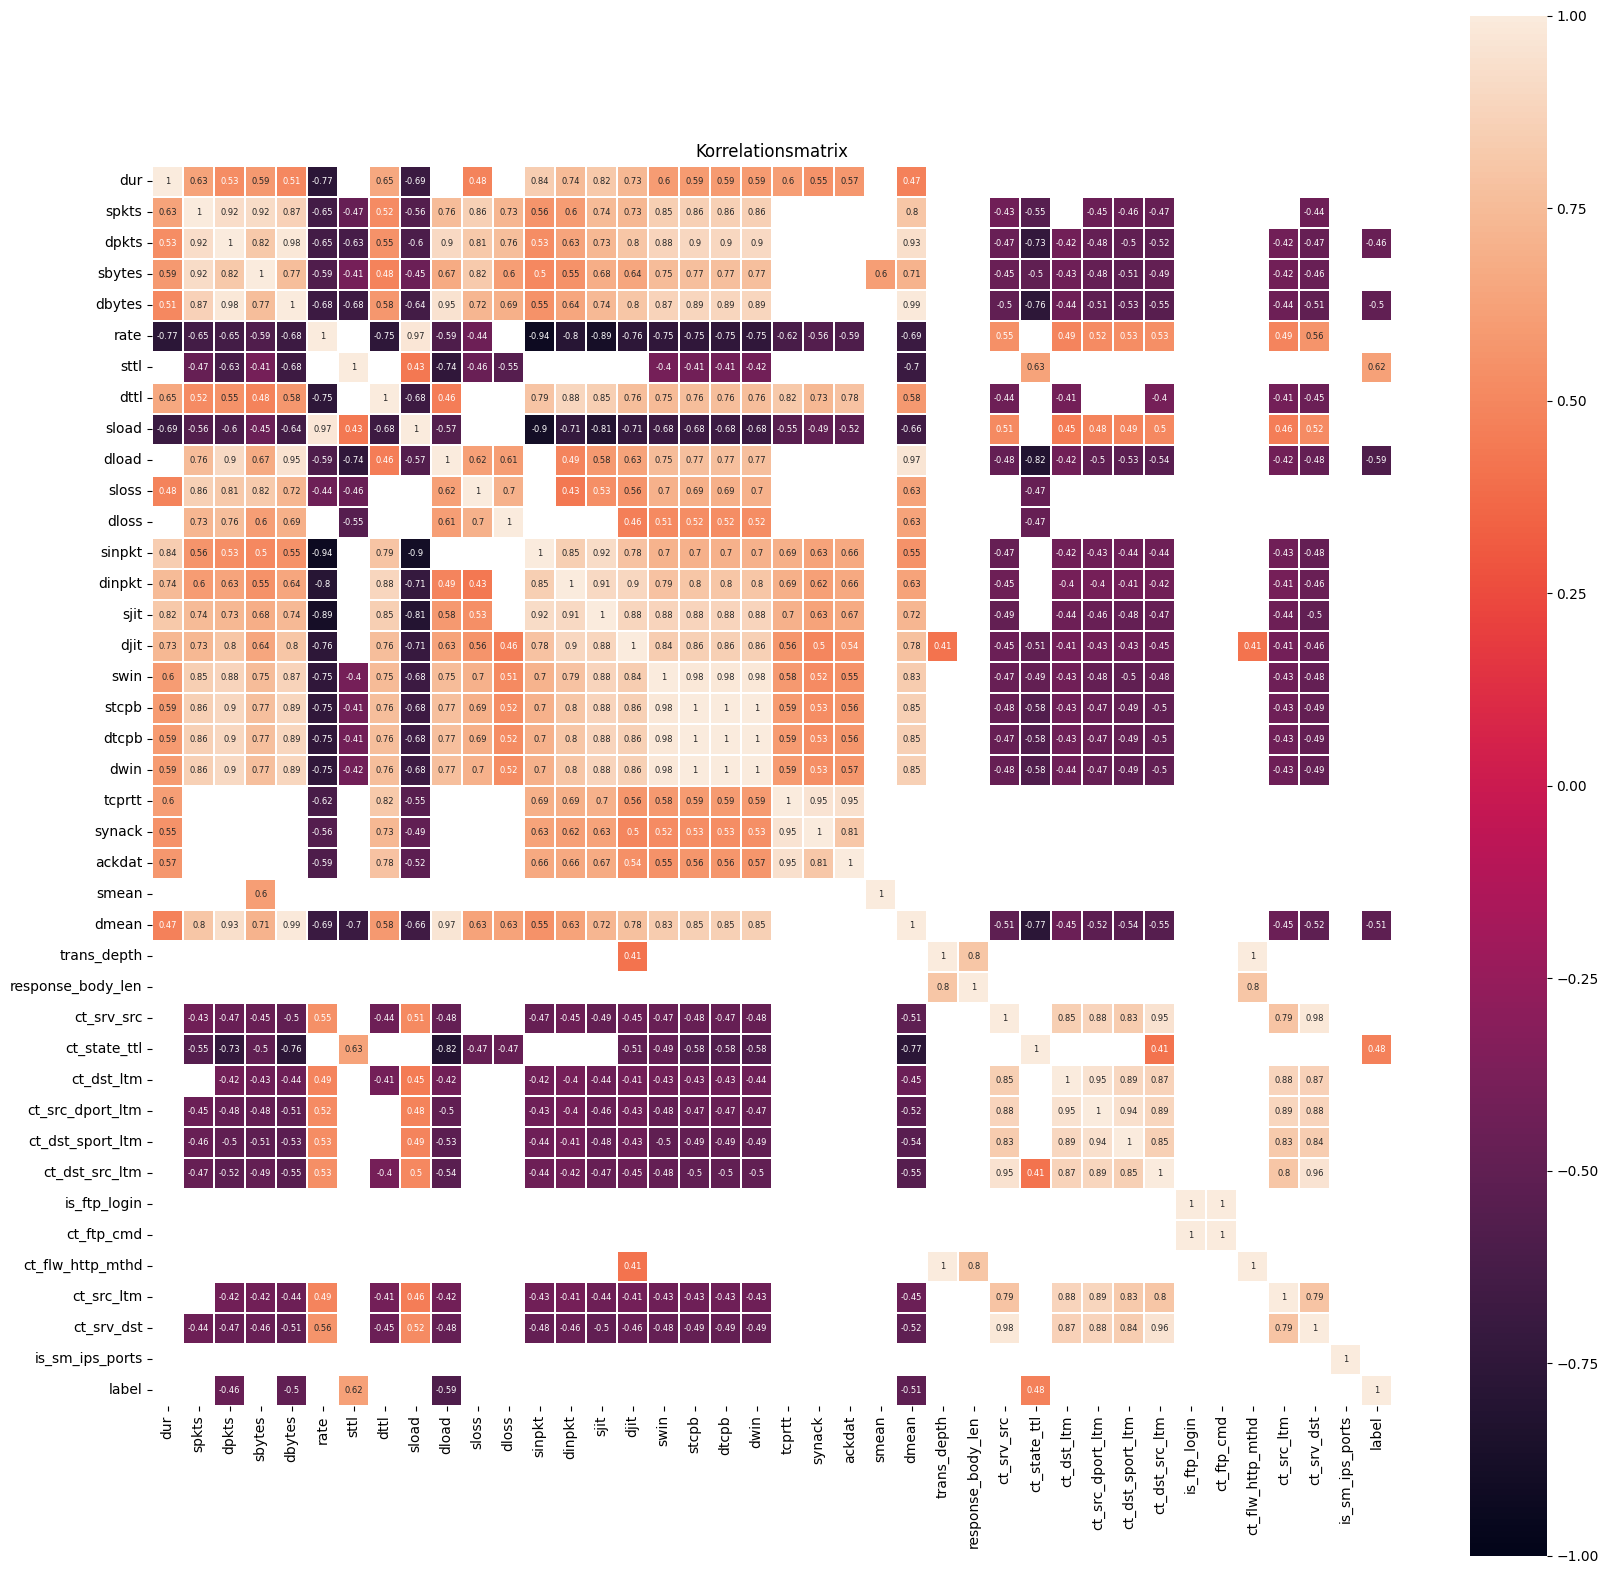

In [26]:
corr_matrix = df_numeric_train.corr()
plt.figure(figsize=(20, 20))

sns.heatmap(corr_matrix[(corr_matrix >= 0.4) | (corr_matrix <= -0.4)], vmax=1.0, 
            vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 6}, square=True)
plt.title('Korrelationsmatrix')
plt.show()

In [27]:
df_num_corr = df_numeric_train.corr(numeric_only=True)['label']
df_num_corr = df_num_corr[df_num_corr >= -1]
print(df_num_corr)

dur                 -0.038107
spkts               -0.358317
dpkts               -0.461601
sbytes              -0.335856
dbytes              -0.497162
rate                 0.314953
sttl                 0.624082
dttl                 0.019369
sload                0.342124
dload               -0.589788
sloss               -0.335394
dloss               -0.340104
sinpkt              -0.137335
dinpkt              -0.075330
sjit                -0.198024
djit                -0.185304
swin                -0.364877
stcpb               -0.338998
dtcpb               -0.338368
dwin                -0.339166
tcprtt              -0.013399
synack              -0.038525
ackdat               0.008813
smean               -0.067186
dmean               -0.513907
trans_depth         -0.001805
response_body_len   -0.076967
ct_srv_src           0.250457
ct_state_ttl         0.476559
ct_dst_ltm           0.247052
ct_src_dport_ltm     0.339795
ct_dst_sport_ltm     0.387176
ct_dst_src_ltm       0.307422
is_ftp_log

In [28]:
golden_features_list = df_num_corr[abs(df_num_corr) > abs(0.4)].sort_values(ascending=False)
print("There are {} strongly correlated values with Target:\n{}".format(len(golden_features_list), golden_features_list))

There are 7 strongly correlated values with Target:
label           1.000000
sttl            0.624082
ct_state_ttl    0.476559
dpkts          -0.461601
dbytes         -0.497162
dmean          -0.513907
dload          -0.589788
Name: label, dtype: float64


## 3. Categorical feature encoding
Combine the categorical features with the numeric features into an array with the shape (257673, 56)

In [30]:
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

In [31]:
feature_names = list(X.columns)
np.shape(X)

(257673, 42)

In [32]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [33]:
np.shape(X)

(257673, 56)

In [34]:
len(feature_names)

42

In [35]:
# Iterate over unique values of 'state' column in the training dataframe,
# starting from the second most frequent value (excluding the most frequent one),
# and insert each value at the beginning of the 'feature_names' list.

for label in list(df_cat_train['state'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat_train['service'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat_train['proto'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)

In [36]:
len(feature_names)

56

## 4. Implementation and modeling

### 4.0 Setup and normalisation 

In [37]:
import time
from sklearn.preprocessing import StandardScaler
# Imports for the evaluation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Imports needed for the classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [38]:
# Creating a dataframe-layout for the model evaluation.
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision',
                                          'F1-Score','time to train','time to predict','total time'])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y, shuffle=True)

In [41]:
# The first columns are booleans therefore only the latter ones will be normalized
sc = StandardScaler()
X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])
X_test[:, 18:] = sc.transform(X_test[:, 18:])

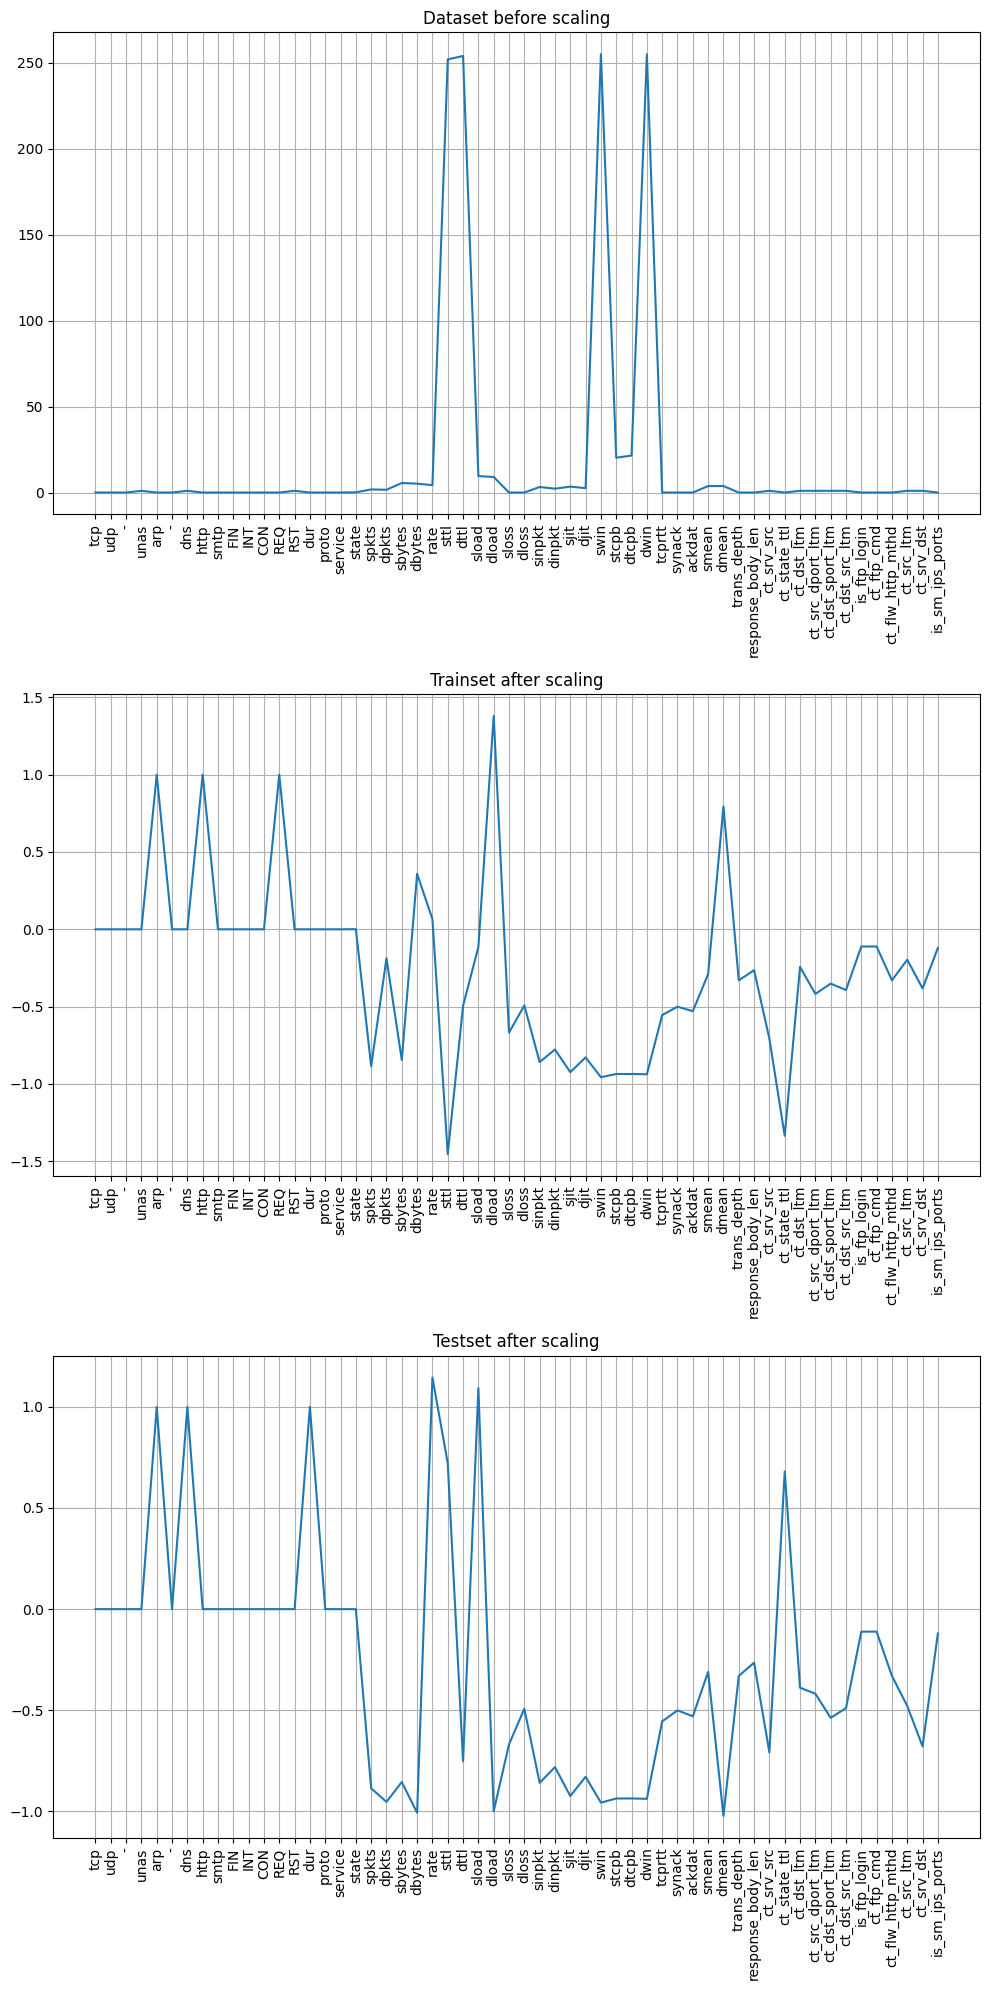

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))

axs[0].plot(np.arange(len(feature_names)), X[0])
axs[0].set_title("Dataset before scaling")
axs[0].grid()
axs[0].set_xticks(np.arange(len(feature_names)))
axs[0].set_xticklabels(feature_names, rotation=90)  

axs[1].plot(np.arange(len(feature_names)), X_train[0])
axs[1].set_title("Trainset after scaling")
axs[1].grid()
axs[1].set_xticks(np.arange(len(feature_names)))
axs[1].set_xticklabels(feature_names, rotation=90)  

axs[2].plot(np.arange(len(feature_names)), X_test[0])
axs[2].set_title("Testset after scaling")
axs[2].grid()
axs[2].set_xticks(np.arange(len(feature_names)))
axs[2].set_xticklabels(feature_names, rotation=90)  

plt.tight_layout()
plt.show()

### 4.1 Classification

In [ ]:
if TRAIN_DATA_FROM_SCRATCH:
    # List of models to train
    models = {
        'Logistische Regression' : LogisticRegression(),
        'k-NN': KNeighborsClassifier(),
        'Entscheidungsbaum': DecisionTreeClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Random Forest': RandomForestClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier()}
    # Parameter to use in grid search
    param_grid = {
        'Logistische Regression': {'max_iter': [5000, 7500], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
        'k-NN': {'n_neighbors': [3, 5, 7], 'leaf_size': [10, 30, 50, 70]},
        'Entscheidungsbaum': {'max_depth': [ 5, 7, 10, 13], 'min_samples_split': [5, 8, 12], 'min_samples_leaf': [3, 5, 7, 15]},
        'Extra Trees': {'n_estimators': [50, 200], 'max_depth': [5, 7, 10, 13]},
        'Random Forest': {'n_estimators': [50, 200], 'max_depth': [5, 7, 10, 13]},
        'GradientBoostingClassifier': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2]}
    }

    results = []
    try:
        for model_name, model in models.items():

            grid_search = GridSearchCV(model, param_grid[model_name], cv=3, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            
            model.set_params(**best_params)
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            start_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_time
            
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            results.append({
                'Modell': model_name,
                'Parameter': best_params,
                'Trainingszeit': training_time,
                'Vorhersagezeit': prediction_time,
                'Genauigkeit': accuracy,
                'Recall': recall,
                'Precision': precision,
                'F1 Score': f1,
            })
            print("Trainierte Modelle:", model_name)
        df_results = pd.DataFrame(results)
        df_results.to_csv('./data/evaluation/df_results_k.csv', index=False)
        
    except Exception as e:
        print(f"Fehler beim Trainieren und Speichern der Ergebnisse: {e}")
        df_results = pd.DataFrame()
else:
    try:
        df_results = pd.read_csv('./data/evaluation/df_results_k.csv')
        print("Ergebnisse erfolgreich geladen.")
    except FileNotFoundError:
        print("Die Datei df_results_k.csv wurde nicht gefunden.")
        df_results = pd.DataFrame()

Trainierte Modelle: Logistische Regression
Trainierte Modelle: k-NN
Trainierte Modelle: Entscheidungsbaum
Trainierte Modelle: Extra Trees
Trainierte Modelle: Random Forest
Trainierte Modelle: GradientBoostingClassifier


### 4.2 Deep-Learning structures 

In [ ]:
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout
from keras import layers
import keras 
from numpy import array
import tensorflow as tf

In [ ]:
results = [] # Empty list for the model evaluation 

In [ ]:
TRAIN_DATA_FROM_SCRATCH = False # Default: False
MODEL_NAME = "Unnamed" # Used for the future model evaluation to recognize the trained model 
# Training parameters
TOTAL_FEATURES = len(feature_names)
EPOCHS = 200 # Default: 200
BATCH_SIZE = 1000 # Default: 1000
LEARNING_RATE = 0.001 # Default: 0.01
EARLY_STOPPING_PATIENCE = 10 # Default: 10; When "EPOCHS" = Train until complete
SPARSITY_WEIGHT = 0.0001  # Used for Sparse autoencoder: default 0.0001

In [ ]:
#The LSTM and GRU input layer must be 3D.
#The meaning of the 3 input dimensions are: samples, time steps, and total amount of features.
#Since we are not using the second input (time steps) the value will be kept at a constant 1
X_train_array = array(X_train) 
X_test_array  = array(X_test)
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0] ,1 ,TOTAL_FEATURES)
X_test_reshaped  = X_test_array.reshape(X_test_array.shape[0] ,1 ,TOTAL_FEATURES) 

In [ ]:
X_train_reshaped.shape

(206138, 1, 56)

#### 4.2.0 Helper Functions

In [ ]:
def evaluate_model(model, X, y_true, print_output=True, number_of_outputs=1):
    """
    Evaluates the performance of a given model on the provided data.

    Parameters:
    - model: The trained model to evaluate.
    - X: Input features for evaluation.
    - y_true: True labels for the input features.
    - print_output: Boolean flag indicating whether to print the evaluation metrics.
    - number_of_outputs: Number of outputs from the model (1 for single output, 2 for probabilities and classes).
        - default: 1, use 2 for SAE 

    Returns:
    - accuracy: Accuracy score of the model based upon the provided labels (y_true)
    - recall: Weighted recall score of the model.
    - precision: Weighted precision score of the model.
    - f1: Weighted F1 score of the model.
    - end_predict: End time of the prediction process.
    """
    if number_of_outputs == 1:
        y_pred = model.predict(X)
    else:
        _, y_pred = model.predict(X)
        
    y_pred_classes = y_pred.argmax(axis=-1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    end_predict = time.time()
    
    if print_output:
        print("Modell:",model.name)
        print("Genauigkeit:", accuracy)
        print("Recall:", recall)
        print("Precision:", precision)
        print("F1 Score:", f1)
        
    return accuracy, recall, precision, f1, end_predict

In [ ]:
def evaluate_model_timeseries(model, X, y_true, print_output=True, number_of_outputs=1):
    """
    Evaluates the performance of a time series model based on reconstructions and true values.

    Parameters:
    - model: The trained time series model to evaluate.
    - X: Input features for evaluation.
    - y_true: True labels for the input features.
    - print_output: Boolean flag indicating whether to print evaluation metrics.
    - number_of_outputs: Number of outputs from the model (1 for single output, 2 for reconstructions and probabilities).
         - default: 1, use 2 for SAE 
         
    Returns: Used for evaluation
    - accuracy: Accuracy score of the model.
    - recall: Weighted recall score of the model.
    - precision: Weighted precision score of the model.
    - f1: Weighted F1 score of the model.
    - end_predict: End time of the prediction process.
    """
    if number_of_outputs == 1:
        reconstructions= model.predict(X)
    else:
        reconstructions, _ = model.predict(X)
    
    mae_loss = tf.keras.losses.mae(reconstructions, X)
    threshold = (np.mean(mae_loss) + np.std(mae_loss))
    y_pred = np.where(np.mean((mae_loss < threshold).numpy().astype(int), axis=1) < 1, 0, 1)
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    end_predict = time.time()
    
    if print_output:
        print("Modell:",model.name)
        print("Genauigkeit:", accuracy)
        print("Recall:", recall)
        print("Precision:", precision)
        print("F1 Score:", f1)
        
    return accuracy, recall, precision, f1, end_predict

In [ ]:
def append_model_reults(model, results, training_time, prediction_time, accuracy, recall, precision, f1):
    """
    Appends evaluation metrics and other information of a model to a list.

    Parameters:
    - model: The trained model to append results for.
    - results: List to append the model results to.
    - training_time: Time taken for training the model.
    - prediction_time: Time taken for making predictions with the model.
    - accuracy: Accuracy score of the model.
    - recall: Weighted recall score of the model.
    - precision: Weighted precision score of the model.
    - f1: Weighted F1 score of the model.

    Returns:
    - results: Updated list with the evaluation metrics.
    """
    results.append({
        'Modell': model.name,
        'Parameter': "",
        'Trainingszeit': training_time,
        'Vorhersagezeit': prediction_time,
        'Genauigkeit': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
        })
    return results

In [ ]:
def save_plot_history_to_json(name, hist):
    """
    Saves training history (epochs, accuracy, loss, validation loss) of a model to a JSON file.

    Parameters:
    - name: Name of the model.
    - hist: History object containing training metrics.

    Returns:
    - None
    """
    try:
        with open('train_histories.json', 'r') as file:
            data = file.read()
            if data:
                list = json.loads(data)
            else:
                list = []
    except FileNotFoundError:
        list = []

    version = 1
    unique_name = f'Model_{name}'

    while any(entry['model_name'] == unique_name for entry in list):
        version += 1
        unique_name = f'Model_{name}_v{version}'

    history_dict = {
        'model_name': unique_name, 
        'epoch': np.array(hist.epoch).tolist(),
    }

    if 'accuracy' in hist.history:
        history_dict['accuracy'] = np.array(hist.history['accuracy']).tolist()
    if 'loss' in hist.history:
        history_dict['loss'] = np.array(hist.history['loss']).tolist()
    if 'val_loss' in hist.history:
        history_dict['val_loss'] = np.array(hist.history['val_loss']).tolist()
    
    list.append(history_dict) 
    with open('train_histories.json', 'w') as file:
        json.dump(list, file)

In [ ]:
def plot_autoencoder_reconstruction(decoded_data, X):
    """
    Plots the reconstruction of input features by an autoencoder model.

    Parameters:
    - decoded_data: Decoded data produced by the autoencoder.
    - X: Input features used for creating the Input curve to calculate the given error.

    Returns:
    - None
    """
    total_subplots = 16
    selected_features = random.sample(range(X.shape[0]), total_subplots)

    plt.figure(figsize=(20, 10))
    for idx, feature_idx in enumerate(selected_features):
        plt.subplot(4, 4, idx + 1)
        plt.plot(X[idx, 0], 'b')
        plt.plot(decoded_data[idx, 0], 'r', linewidth=0.5)
        plt.fill_between(np.arange(TOTAL_FEATURES), decoded_data[idx, 0], X[idx, 0], color='lightcoral', alpha=0.7)
        plt.title(f'Feature {feature_idx + 1}')
        plt.legend(labels=["Input", "Reconstruction", "Error"])
        plt.suptitle("Modell: {model}".format(model=MODEL_NAME), fontsize=20)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_mae_distribution(model, X, y_true, number_of_outputs=1):
    """
    Plots the distribution of Mean Absolute Error (MAE) loss for input data.

    Parameters:
    - model: The trained model used for prediction.
    - X: Input features for evaluation.
    - y_true: True labels corresponding to the input features.
    - number_of_outputs: Number of outputs from the model (1 for single output, 2 for reconstructions and probabilities).

    Returns:
    - None
    """
    if number_of_outputs == 1:
        reconstructions = model.predict(X)
    else:
        reconstructions,_ = model.predict(X)
        
    mae_loss = tf.keras.losses.mae(reconstructions, X)
    threshold = (np.mean(mae_loss) + np.std(mae_loss))
    y_pred = np.where(np.mean((mae_loss < threshold).numpy().astype(int), axis=1) < 1, 0, 1)

    accuracy = accuracy_score(y_true, y_pred)
    
    loss_reduced = tf.reshape(mae_loss, [mae_loss.shape[0], -1])
    
    plt.title("Model: {model}, Threshold: {thresh:.2f}, Accuracy: {acc:.2%}".format(model=MODEL_NAME,thresh=threshold, acc=accuracy))
    plt.hist(loss_reduced.numpy(), bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()

#### 4.2.1 MLP Classifier

In [ ]:
def build_model_mlp():
    model = Sequential(name=MODEL_NAME)
    model.add(Dense(128, input_dim=TOTAL_FEATURES, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(20, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics='accuracy')
    
    return model

In [ ]:
mlp_model = build_model_mlp()
mlp_model.summary()

In [ ]:
start = time.time()
history = mlp_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
end_train = time.time()

Epoch 1/200
209/209 - 1s - loss: 0.4006 - accuracy: 0.8668 - val_loss: 0.1682 - val_accuracy: 0.9143 - 1s/epoch - 7ms/step
Epoch 2/200
209/209 - 1s - loss: 0.1620 - accuracy: 0.9160 - val_loss: 0.1555 - val_accuracy: 0.9209 - 683ms/epoch - 3ms/step
Epoch 3/200
209/209 - 1s - loss: 0.1544 - accuracy: 0.9208 - val_loss: 0.1503 - val_accuracy: 0.9242 - 763ms/epoch - 4ms/step
Epoch 4/200
209/209 - 1s - loss: 0.1492 - accuracy: 0.9241 - val_loss: 0.1453 - val_accuracy: 0.9262 - 667ms/epoch - 3ms/step
Epoch 5/200
209/209 - 1s - loss: 0.1454 - accuracy: 0.9270 - val_loss: 0.1470 - val_accuracy: 0.9270 - 676ms/epoch - 3ms/step
Epoch 6/200
209/209 - 1s - loss: 0.1411 - accuracy: 0.9295 - val_loss: 0.1440 - val_accuracy: 0.9262 - 644ms/epoch - 3ms/step
Epoch 7/200
209/209 - 1s - loss: 0.1397 - accuracy: 0.9302 - val_loss: 0.1382 - val_accuracy: 0.9318 - 598ms/epoch - 3ms/step
Epoch 8/200
209/209 - 1s - loss: 0.1393 - accuracy: 0.9305 - val_loss: 0.1370 - val_accuracy: 0.9298 - 633ms/epoch - 3ms/

In [ ]:
accuracy, recall, precision, f1, end_predict = evaluate_model(mlp_model, X_test, y_test, True, 1)

   1/1611 [..............................] - ETA: 38s

1611/1611 [==============================] - 2s 1ms/step
Modell: MLP_Classifier
Genauigkeit: 0.9452216939943727
Recall: 0.9452216939943727
Precision: 0.9458816592533312
F1 Score: 0.945409003546821


In [ ]:
results = append_model_reults(mlp_model, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

#### 4.2.2 LSTM

In [ ]:
# LSTM_1 = 128 X 64 X 32 X 20; 0.2 dropoout on each layer; 1 Dropout-Layer before Dense -> 91 test 93 train
# LSTM_2 = 256 X 128 X 64 X 32 X 20; 0.2 dropoout on each layer; 1 Dropout-Layer before Dense -> 91 test 93 train
# LSTM_3 = 256 X 128 X 64 X 32 X 20; -> Currently the best model -> 94.5 test 96 train

In [ ]:
def build_model_lstm():
    model = Sequential(name=MODEL_NAME)
    
    model.add(LSTM(256, return_sequences=True, input_shape=(1, TOTAL_FEATURES), name="LSTM1"))
    model.add(LSTM(128, return_sequences=True, name="LSTM2"))
    model.add(LSTM(64, return_sequences=True, name="LSTM3"))
    model.add(LSTM(32, return_sequences=True, name="LSTM4"))
    
    model.add(Dense(20, activation='softmax')) 
    
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model_lstm = build_model_lstm()
model_lstm.summary()

Model: "LSTM_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 1, 256)            320512    
                                                                 
 LSTM2 (LSTM)                (None, 1, 128)            197120    
                                                                 
 LSTM3 (LSTM)                (None, 1, 64)             49408     
                                                                 
 LSTM4 (LSTM)                (None, 1, 32)             12416     
                                                                 
 dense_3 (Dense)             (None, 1, 20)             660       
                                                                 
Total params: 580,116
Trainable params: 580,116
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
history = model_lstm.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
end_train = time.time()

Epoch 1/200
207/207 - 6s - loss: 0.8482 - accuracy: 0.8059 - 6s/epoch - 29ms/step
Epoch 2/200
207/207 - 2s - loss: 0.2621 - accuracy: 0.8986 - 2s/epoch - 7ms/step
Epoch 3/200
207/207 - 1s - loss: 0.2057 - accuracy: 0.9133 - 1s/epoch - 7ms/step
Epoch 4/200
207/207 - 1s - loss: 0.1591 - accuracy: 0.9226 - 1s/epoch - 7ms/step
Epoch 5/200
207/207 - 1s - loss: 0.1525 - accuracy: 0.9253 - 1s/epoch - 7ms/step
Epoch 6/200
207/207 - 1s - loss: 0.1487 - accuracy: 0.9267 - 1s/epoch - 7ms/step
Epoch 7/200
207/207 - 1s - loss: 0.1464 - accuracy: 0.9278 - 1s/epoch - 7ms/step
Epoch 8/200
207/207 - 1s - loss: 0.1445 - accuracy: 0.9282 - 1s/epoch - 7ms/step
Epoch 9/200
207/207 - 1s - loss: 0.1411 - accuracy: 0.9299 - 1s/epoch - 7ms/step
Epoch 10/200
207/207 - 1s - loss: 0.1398 - accuracy: 0.9304 - 1s/epoch - 7ms/step
Epoch 11/200
207/207 - 1s - loss: 0.1382 - accuracy: 0.9313 - 1s/epoch - 7ms/step
Epoch 12/200
207/207 - 1s - loss: 0.1372 - accuracy: 0.9316 - 1s/epoch - 7ms/step
Epoch 13/200
207/207 - 1

In [ ]:
accuracy, recall, precision, f1, end_predict = evaluate_model(model_lstm, X_test_reshaped, y_test, True, 1)

1611/1611 [==============================] - 7s 3ms/step
Modell: LSTM_3
Genauigkeit: 0.9436693509265548
Recall: 0.9436693509265548
Precision: 0.9442254056128405
F1 Score: 0.9438386424483918


In [ ]:
results = append_model_reults(model_lstm, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

#### 4.2.3 GRU

In [ ]:
# GRU_1 = 256 X 128 X 64 X 32 X 20; -> 94.2 test 97 train
# GRU_2 = 256 X 128 X 64 X 32 X 20; 1 Dropout-Layer 50% before Dense -> 94.44 test 96 train
# GRU_3 = 256 X 128 X 64 X 32 X 48; 1 Dropout-Layer 50% before Dense -> 94.45 test 96 train -> fastest model

def build_model_gru():
    model = Sequential(name=MODEL_NAME)
    
    model.add(GRU(256, return_sequences=True, input_shape=(1, TOTAL_FEATURES), name="GRU1"))
    model.add(GRU(128, return_sequences=True, name="GRU2"))
    model.add(GRU(64, return_sequences=True, name="GRU3"))
    model.add(GRU(32, return_sequences=True, name="GRU4"))
    model.add(Dropout(0.5))
    model.add(Dense(48, activation='softmax', name="FinalDense")) 
    
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model_gru = build_model_gru()
model_gru.summary()

Model: "GRU_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU1 (GRU)                  (None, 1, 256)            241152    
                                                                 
 GRU2 (GRU)                  (None, 1, 128)            148224    
                                                                 
 GRU3 (GRU)                  (None, 1, 64)             37248     
                                                                 
 GRU4 (GRU)                  (None, 1, 32)             9408      
                                                                 
 dropout_6 (Dropout)         (None, 1, 32)             0         
                                                                 
 FinalDense (Dense)          (None, 1, 48)             1584      
                                                                 
Total params: 437,616
Trainable params: 437,616
Non-trainable

In [ ]:
start = time.time()
history = model_gru.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
end_train = time.time()

Epoch 1/200
207/207 - 6s - loss: 0.8277 - accuracy: 0.8380 - 6s/epoch - 30ms/step
Epoch 2/200
207/207 - 1s - loss: 0.2126 - accuracy: 0.9075 - 1s/epoch - 7ms/step
Epoch 3/200
207/207 - 1s - loss: 0.1843 - accuracy: 0.9141 - 1s/epoch - 7ms/step
Epoch 4/200
207/207 - 2s - loss: 0.1730 - accuracy: 0.9181 - 2s/epoch - 8ms/step
Epoch 5/200
207/207 - 1s - loss: 0.1648 - accuracy: 0.9214 - 1s/epoch - 6ms/step
Epoch 6/200
207/207 - 1s - loss: 0.1596 - accuracy: 0.9237 - 1s/epoch - 6ms/step
Epoch 7/200
207/207 - 1s - loss: 0.1540 - accuracy: 0.9262 - 1s/epoch - 6ms/step
Epoch 8/200
207/207 - 1s - loss: 0.1528 - accuracy: 0.9258 - 1s/epoch - 6ms/step
Epoch 9/200
207/207 - 1s - loss: 0.1487 - accuracy: 0.9274 - 1s/epoch - 6ms/step
Epoch 10/200
207/207 - 1s - loss: 0.1493 - accuracy: 0.9261 - 1s/epoch - 6ms/step
Epoch 11/200
207/207 - 1s - loss: 0.1456 - accuracy: 0.9279 - 1s/epoch - 6ms/step
Epoch 12/200
207/207 - 1s - loss: 0.1444 - accuracy: 0.9296 - 1s/epoch - 6ms/step
Epoch 13/200
207/207 - 1

In [ ]:
accuracy, recall, precision, f1, end_predict = evaluate_model(model_gru, X_test_reshaped, y_test, True, 1)

1611/1611 [==============================] - 5s 3ms/step
Modell: GRU_3
Genauigkeit: 0.9445231396138547
Recall: 0.9445231396138547
Precision: 0.944504913701851
F1 Score: 0.9445137054763902


In [ ]:
results = append_model_reults(model_gru, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

#### 4.2.4 Autoencoder (simple variant) 
- **Variant without timestamps:** The autoencoder do not support a valid decoder while being used as a supervised model. 
- **Anomaly detection:** Henceforth, it can be kept simple, as we did in the approach to anomaly detection for the classification algorithms.
    - **Supervised:** To train a supervised model all thats needed is the correct loss function (sparse) for calssification and the X and y values. 
    - **Unsupervised:** To train an unsupervised model all thats needed is the correct loss function (mse) without the labels (y) for the reconstruction with a decoder.

In [ ]:
# Autoencoder_1: encoder = 32 X 16 X 8; decoder = 16 X 32; -> 93.85 test 93 train
# Autoencoder_2: encoder = 32 X 16 X 8; decoder = 8 X 16 X 32; -> 93.9 test 93 train -> deutlich langsamer
# Autoencoder_3: encoder = 64 X 32 X 16; decoder = 32 X 64; -> 94.1 test 93.34 train -> am schnellsten und besten -> 2. 5.5s
# Autoencoder_4: encoder = 128 X 64 X 32 X 16; decoder = 32 X 64 X 128; -> 94.09 test 95.1 train -> am langsamsten 
# Autoencoder_5: encoder = 128 X 64 X 32; decoder = 32 X 64; -> 94.4 test 95.2 train -> schnell und am besten -> 1. 
# Autoencoder_6: encoder = 128 X 64 X 32; decoder = 64 X 128; -> 94 test 95.4 train -> keine Verbesserung
# Autoencoder_7: encoder = 256 X 128 X 64; decoder = 32 X 64; -> 94.35 test 96 train -> gute Genauigkeite + schnellste PTime -> 5s 
# Autoencoder_8: encoder = 256 X 128 X 64; decoder = 32 X 64; Dropout 50% -> bad
# Autoencoder_9: encoder = 256 X 128; decoder = 32 X 64; -> 94.38 test 96 train -> bestes Modell momentan
# Autoencoder_10: encoder = 256 X 128; decoder = 16 X 32; -> 94.39 test 95.5 train -> bestes Modell momentan
# Autoencoder_11: encoder = 256 X 128; decoder = 32; -> 94.3 test 95.7 train -> PTime 4.3s -> am schnellsten
# Autoencoder_12: encoder = 256 X 128; decoder = 128; -> 94.4 test 96.3 train -> PTime 4.7s -> #### Bestes Modell.
# Autoencoder_13: encoder = 512 X 256; decoder = 128; -> x test x train -> PTime x -> am schnellsten
# Autoencoder_14: encoder = 256 X 128; decoder = 64; loss = mae, metrics=['accuracy']; bad
# Autoencoder_15: encoder = 256 X 128; decoder = 64; loss = mae; bad

In [ ]:
class SimpleAutoencoder(Model):
    def __init__(self, name="AnomalyDetector"):
        super(SimpleAutoencoder, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(TOTAL_FEATURES, activation="linear")],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_autoencoder = SimpleAutoencoder(name="Autoencoder")
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_autoencoder.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Supervised learning
#model_autoencoder.compile(optimizer=opt, loss='mse', metrics=['accuracy']) # Unsupervised learning

In [ ]:
start = time.time()
histroy = model_autoencoder.compile(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Supervised learning
# history = model_autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, 
#                               shuffle=True, validation_data=(X_test_reshaped, X_test_reshaped)) # Unsupervised learning
end_train = time.time()

Epoch 1/200
207/207 [==============================] - 3s 6ms/step - loss: 0.1449 - val_loss: 0.0620
Epoch 2/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0480 - val_loss: 0.0405
Epoch 3/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0365 - val_loss: 0.0339
Epoch 4/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0320 - val_loss: 0.0303
Epoch 5/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0284 - val_loss: 0.0253
Epoch 6/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 7/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 8/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0218 - val_loss: 0.0220
Epoch 9/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 10/200
207/207 [==============================] - 1s 5ms/step - loss: 0.0205 - val_lo

In [ ]:
accuracy, recall, precision, f1, end_predict = evaluate_model_timeseries(model_autoencoder, X_test_reshaped, y_test, True, 1)

1611/1611 [==============================] - 4s 2ms/step
Modell: Autoencoder
Genauigkeit: 0.6291452410982827
Recall: 0.6291452410982827
Precision: 0.567965553080559
F1 Score: 0.5402931876183356


1611/1611 [==============================] - 3s 2ms/step


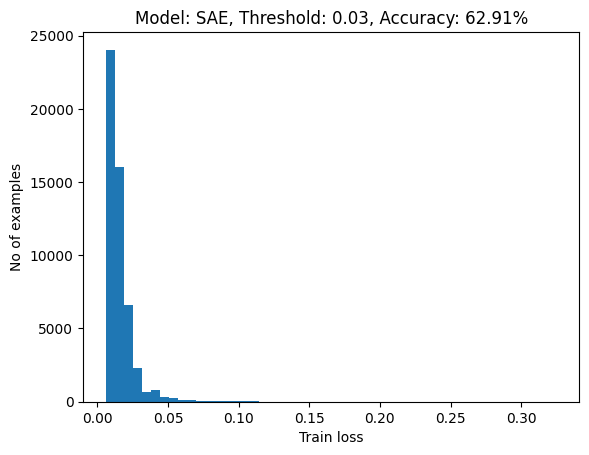

In [ ]:
plot_mae_distribution(model_autoencoder, X_test_reshaped, y_test, number_of_outputs=1)

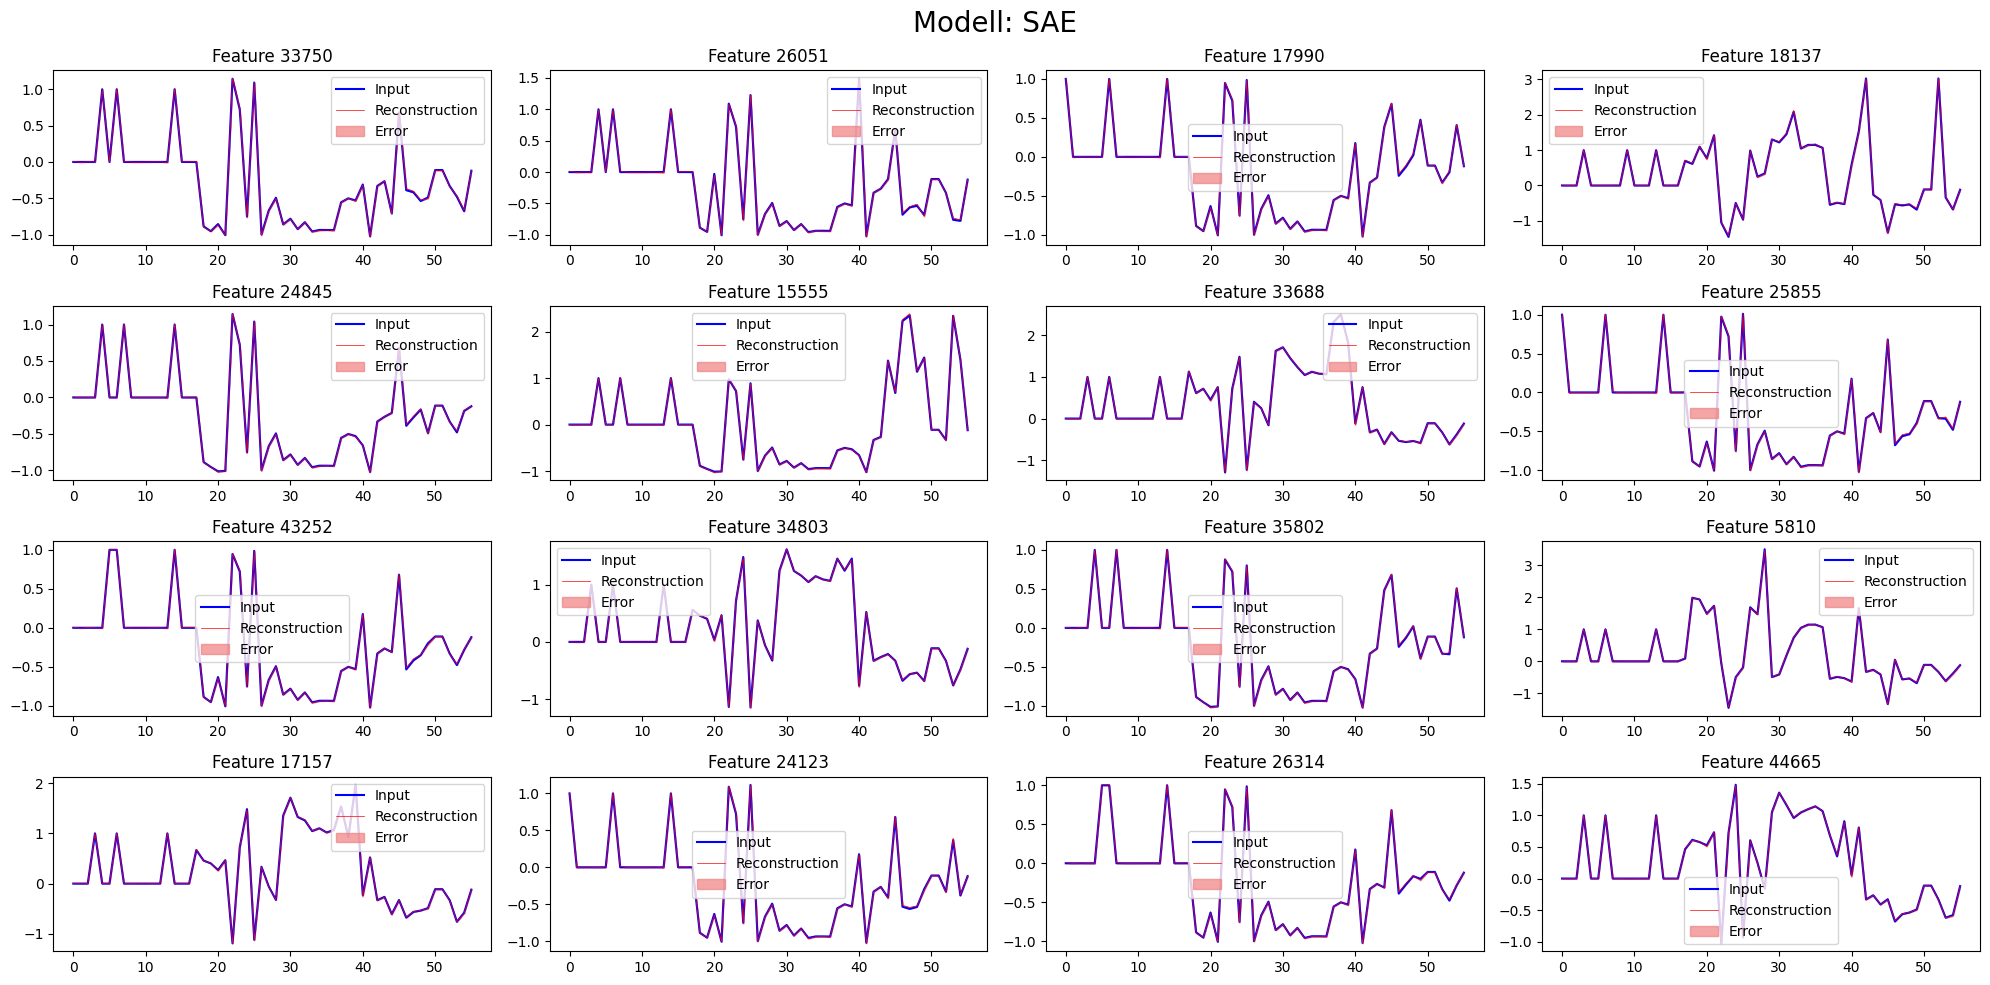

In [ ]:
encoded_data = model_autoencoder.encoder(X_test_reshaped).numpy()
decoded_data = model_autoencoder.decoder(encoded_data).numpy()

plot_autoencoder_reconstruction(decoded_data, X_test_reshaped)

In [ ]:
# Goal: Train the same model for classification and reconstruction
# Final: Can have 2 loss functions but only one dataset which means it ain't usable for both yet.
class SupervisedAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, name="SAE"):
        super(SupervisedAutoencoder, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Flatten(input_shape=input_shape),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(input_shape[0] * input_shape[1], activation='linear'),
            layers.Reshape(input_shape)
        ])
        
        self.classification_layer = tf.keras.layers.Dense(TOTAL_FEATURES, activation='softmax')
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classification = self.classification_layer(encoded)
        return decoded, classification

model_autoencoder = SupervisedAutoencoder(input_shape=(1, TOTAL_FEATURES), name=MODEL_NAME)
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_autoencoder.compile(optimizer=opt, loss=['mse', 'sparse_categorical_crossentropy'], metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

In [ ]:
start = time.time()
# histroy = model_autoencoder.compile(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Supervised learning
history = model_autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                                verbose=2, validation_data=(X_test_reshaped, X_test_reshaped), callbacks=[early_stopping])
end_train = time.time()
accuracy, recall, precision, f1, end_predict = evaluate_model(model_autoencoder, X_test_reshaped, y_test, True, 2) # Needs to be 2 since we habe 2 outputs

Epoch 1/200
207/207 - 2s - loss: 0.0712 - output_1_loss: 0.0712 - output_1_accuracy: 0.5872 - output_2_accuracy: 0.0094 - val_loss: 0.0067 - val_output_1_loss: 0.0067 - val_output_1_accuracy: 0.7601 - val_output_2_accuracy: 1.7464e-04 - 2s/epoch - 7ms/step
Epoch 2/200
207/207 - 1s - loss: 0.0041 - output_1_loss: 0.0041 - output_1_accuracy: 0.8047 - output_2_accuracy: 9.7022e-05 - val_loss: 0.0027 - val_output_1_loss: 0.0027 - val_output_1_accuracy: 0.8543 - val_output_2_accuracy: 3.8809e-05 - 723ms/epoch - 3ms/step
Epoch 3/200
207/207 - 1s - loss: 0.0021 - output_1_loss: 0.0021 - output_1_accuracy: 0.8610 - output_2_accuracy: 5.8213e-05 - val_loss: 0.0017 - val_output_1_loss: 0.0017 - val_output_1_accuracy: 0.8771 - val_output_2_accuracy: 3.8809e-05 - 698ms/epoch - 3ms/step
Epoch 4/200
207/207 - 1s - loss: 0.0014 - output_1_loss: 0.0014 - output_1_accuracy: 0.8777 - output_2_accuracy: 4.3660e-05 - val_loss: 0.0012 - val_output_1_loss: 0.0012 - val_output_1_accuracy: 0.8599 - val_output

c:\Users\Alexej\miniconda3\envs\simple-htr-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alexej\miniconda3\envs\simple-htr-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy, recall, precision, f1, end_predict = evaluate_model_timeseries(model_autoencoder, X_test_reshaped, y_test, True, 2) # Testing model

1611/1611 [==============================] - 2s 1ms/step
Modell: SAE
Genauigkeit: 0.6334529931114776
Recall: 0.6334529931114776
Precision: 0.5813930313327613
F1 Score: 0.5484448440378251


In [ ]:
results = append_model_reults(model_autoencoder, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

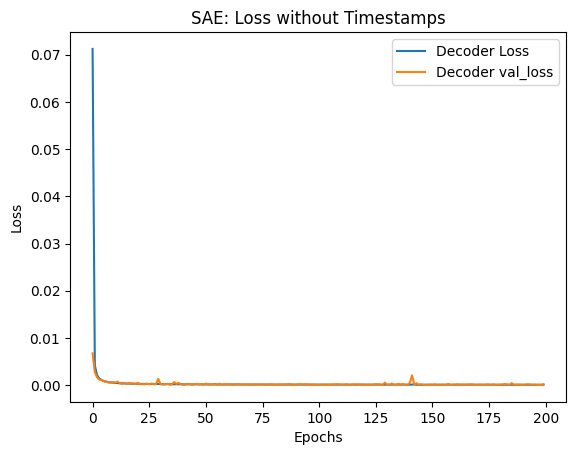

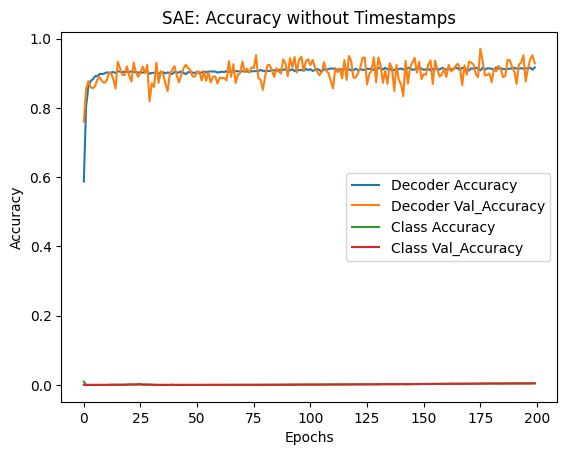

In [ ]:
# Plot der Verlustfunktion
plt.plot(history.history['output_1_loss'], label='Decoder Loss')
plt.plot(history.history['val_output_1_loss'], label='Decoder val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(model_autoencoder.name + ': Loss without Timestamps')
plt.legend()
plt.show()

# Plot der Genauigkeit
plt.plot(history.history['output_1_accuracy'], label='Decoder Accuracy')
plt.plot(history.history['val_output_1_accuracy'], label='Decoder Val_Accuracy')
plt.plot(history.history['output_2_accuracy'], label='Class Accuracy')
plt.plot(history.history['val_output_2_accuracy'], label='Class Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(model_autoencoder.name + ': Accuracy without Timestamps')
plt.legend()
plt.show()


#### 4.2.5 Autoencoder with conv

In [ ]:
#model_autoencoder_test.build(input_shape=(None, 1, 56)) # for debugging

x:  (None, 1, 56)
Shape nach Encoder: (None, 1, 128)
Shape nach Decoder: (None, 1, 56)


In [ ]:
# Best model ConvolutionalAutoencoder_6
class ConvolutionalAnomalyDetector(Model):
    def __init__(self, name="ConvolutionalAnomalyDetector"):
        super(ConvolutionalAnomalyDetector, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu')],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Conv1DTranspose(filters=TOTAL_FEATURES, kernel_size=3, activation='linear', padding='same')],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_conv_autoencoder = ConvolutionalAnomalyDetector(name="ConvolutionalAutoencoder_6")
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_conv_autoencoder.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class ConvolutionalAnomalyDetector(Model):
    def __init__(self, name="ConvolutionalAnomalyDetector"):
        super(ConvolutionalAnomalyDetector, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1D(filters=16, kernel_size=7, padding="same", activation="relu"),
            layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", activation="relu"),
            layers.Dropout(rate=0.2)],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", activation="relu"),
            layers.Conv1DTranspose(filters=TOTAL_FEATURES, kernel_size=3, activation='linear', padding='same')],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_conv_autoencoder = ConvolutionalAnomalyDetector(name="ConvolutionalAutoencoder_9")
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_conv_autoencoder.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
history = model_conv_autoencoder.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Training model
end_train = time.time()
accuracy, recall, precision, f1, end_predict = evaluate_model(model_conv_autoencoder, X_test_reshaped, y_test, True, 1) # Testing model

Epoch 1/200
207/207 - 19s - loss: 0.4567 - accuracy: 0.8733 - 19s/epoch - 91ms/step
Epoch 2/200
207/207 - 1s - loss: 0.1639 - accuracy: 0.9156 - 653ms/epoch - 3ms/step
Epoch 3/200
207/207 - 1s - loss: 0.1531 - accuracy: 0.9232 - 669ms/epoch - 3ms/step
Epoch 4/200
207/207 - 1s - loss: 0.1498 - accuracy: 0.9238 - 636ms/epoch - 3ms/step
Epoch 5/200
207/207 - 1s - loss: 0.1446 - accuracy: 0.9279 - 666ms/epoch - 3ms/step
Epoch 6/200
207/207 - 1s - loss: 0.1428 - accuracy: 0.9283 - 659ms/epoch - 3ms/step
Epoch 7/200
207/207 - 1s - loss: 0.1420 - accuracy: 0.9288 - 644ms/epoch - 3ms/step
Epoch 8/200
207/207 - 1s - loss: 0.1389 - accuracy: 0.9306 - 684ms/epoch - 3ms/step
Epoch 9/200
207/207 - 1s - loss: 0.1382 - accuracy: 0.9310 - 643ms/epoch - 3ms/step
Epoch 10/200
207/207 - 1s - loss: 0.1365 - accuracy: 0.9322 - 633ms/epoch - 3ms/step
Epoch 11/200
207/207 - 1s - loss: 0.1366 - accuracy: 0.9315 - 703ms/epoch - 3ms/step
Epoch 12/200
207/207 - 1s - loss: 0.1359 - accuracy: 0.9325 - 715ms/epoch 

In [ ]:
results = append_model_reults(model_conv_autoencoder, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

#### 4.2.6 Sparse Autoencoder

In [ ]:
# SparseAutoencoder_1: SPARSITY_WEIGHT = 0.01
# SparseAutoencoder_2: SPARSITY_WEIGHT = 1
# SparseAutoencoder_3: SPARSITY_WEIGHT = 0.1
# SparseAutoencoder_4: SPARSITY_WEIGHT = 0.001
# SparseAutoencoder_5: SPARSITY_WEIGHT = 0.0001
# SparseAutoencoder_6: SPARSITY_WEIGHT = 0.0001 + Autoencoder 12 design

In [ ]:
# SparseAutoencoder_6:
class SparseAutoencoder(Model):
    def __init__(self, name="SparseAutoencoder"):
        super(SparseAutoencoder, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(TOTAL_FEATURES, activation="linear")],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_sparse = SparseAutoencoder(name=MODEL_NAME)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# model_sparse.compile(optimizer=opt, loss="mse", metrics=['accuracy'])
model_sparse.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# The initial varaint. Can be ignored
class SparseAutoencoder(Model):
    def __init__(self, name="SparseAutoencoder"):
        super(SparseAutoencoder, self).__init__(name=name)
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(64, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(32, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(16, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT))],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(64, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(256, activation="relu", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT)),
            layers.Dense(TOTAL_FEATURES, activation="linear", activity_regularizer=tf.keras.regularizers.l1(SPARSITY_WEIGHT))],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_sparse = SparseAutoencoder(name=MODEL_NAME)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# model_sparse.compile(optimizer=opt, loss="mse")
model_sparse.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
history = model_sparse.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Training model
#history = model_sparse.fit(X_train_reshaped, X_train_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_reshaped, X_test_reshaped))
end_train = time.time()
accuracy, recall, precision, f1, end_predict = evaluate_model(model_sparse, X_test_reshaped, y_test, True) # Testing model

Epoch 1/200
207/207 - 3s - loss: 0.4332 - accuracy: 0.7467 - 3s/epoch - 17ms/step
Epoch 2/200
207/207 - 2s - loss: 0.1799 - accuracy: 0.9225 - 2s/epoch - 9ms/step
Epoch 3/200
207/207 - 2s - loss: 0.1598 - accuracy: 0.9273 - 2s/epoch - 9ms/step
Epoch 4/200
207/207 - 2s - loss: 0.1501 - accuracy: 0.9303 - 2s/epoch - 10ms/step
Epoch 5/200
207/207 - 2s - loss: 0.1460 - accuracy: 0.9308 - 2s/epoch - 9ms/step
Epoch 6/200
207/207 - 2s - loss: 0.1414 - accuracy: 0.9331 - 2s/epoch - 9ms/step
Epoch 7/200
207/207 - 2s - loss: 0.1386 - accuracy: 0.9341 - 2s/epoch - 10ms/step
Epoch 8/200
207/207 - 2s - loss: 0.1381 - accuracy: 0.9335 - 2s/epoch - 10ms/step
Epoch 9/200
207/207 - 2s - loss: 0.1355 - accuracy: 0.9347 - 2s/epoch - 10ms/step
Epoch 10/200
207/207 - 2s - loss: 0.1334 - accuracy: 0.9352 - 2s/epoch - 10ms/step
Epoch 11/200
207/207 - 2s - loss: 0.1331 - accuracy: 0.9360 - 2s/epoch - 9ms/step
Epoch 12/200
207/207 - 2s - loss: 0.1318 - accuracy: 0.9361 - 2s/epoch - 9ms/step
Epoch 13/200
207/20

In [ ]:
results = append_model_reults(model_sparse, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)

In [ ]:
save_plot_history_to_json(MODEL_NAME, history)

#### 4.2.7 Sequence-to-sequence Autoencoder

In [ ]:
class SequenceToSequenceAutoencoder(Model):
    def __init__(self, name="SequenceToSequenceAutoencoder"):
        super(SequenceToSequenceAutoencoder, self).__init__(name=name)
        
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation="relu", return_sequences=True),],
            name="encoder")
        
        self.decoder = tf.keras.Sequential([
            layers.LSTM(64, activation="relu", return_sequences=True),
            layers.TimeDistributed(layers.Dense(TOTAL_FEATURES, activation="linear"))],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_seq = SequenceToSequenceAutoencoder(name=MODEL_NAME)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_seq.compile(optimizer=opt, loss="mse", metrics=['accuracy'])
#model_seq.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
#history = model_seq.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Supervised learning
history = model_seq.fit(X_train_reshaped, X_train_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_reshaped, X_test_reshaped), verbose=2)
end_train = time.time()
accuracy, recall, precision, f1, end_predict = evaluate_model_timeseries(model_seq, X_test_reshaped, y_test, True, 1)

Epoch 1/200
207/207 - 4s - loss: 0.4972 - accuracy: 0.0355 - val_loss: 0.3742 - val_accuracy: 0.0190 - 4s/epoch - 19ms/step
Epoch 2/200
207/207 - 2s - loss: 0.3706 - accuracy: 0.0628 - val_loss: 0.3653 - val_accuracy: 0.1085 - 2s/epoch - 9ms/step
Epoch 3/200
207/207 - 2s - loss: 0.3654 - accuracy: 0.0879 - val_loss: 0.3620 - val_accuracy: 0.0769 - 2s/epoch - 9ms/step
Epoch 4/200
207/207 - 2s - loss: 0.3636 - accuracy: 0.0745 - val_loss: 0.3613 - val_accuracy: 0.0712 - 2s/epoch - 8ms/step
Epoch 5/200
207/207 - 2s - loss: 0.3626 - accuracy: 0.0658 - val_loss: 0.3601 - val_accuracy: 0.0634 - 2s/epoch - 8ms/step
Epoch 6/200
207/207 - 2s - loss: 0.3617 - accuracy: 0.0602 - val_loss: 0.3593 - val_accuracy: 0.0573 - 2s/epoch - 8ms/step
Epoch 7/200
207/207 - 2s - loss: 0.3612 - accuracy: 0.0571 - val_loss: 0.3590 - val_accuracy: 0.0570 - 2s/epoch - 8ms/step
Epoch 8/200
207/207 - 2s - loss: 0.3605 - accuracy: 0.0573 - val_loss: 0.3584 - val_accuracy: 0.0588 - 2s/epoch - 8ms/step
Epoch 9/200
207

In [ ]:
results = append_model_reults(model_seq, results, end_train - start, end_predict - end_train, accuracy, recall, precision, f1)
save_plot_history_to_json(MODEL_NAME, history)

In [ ]:
encoded_data = model_seq.encoder(X_test_reshaped).numpy()
plot_autoencoder_reconstruction(model_seq.decoder(encoded_data).numpy(), X_test_reshaped)

In [ ]:
plot_mae_distribution(model_seq, X_train_reshaped, y_train)

#### 4.2.8 Variational-Autoencoder (VAE)
After some simple testing the VAE got benched and is unusable for any kind of evaluation

In [ ]:
from keras import backend as K

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VariationalAutoencoder(Model):
    def __init__(self, name="VariationalAutoencoder"):
        super(VariationalAutoencoder, self).__init__(name=name)
        
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation="relu"),
            layers.Dense(TOTAL_FEATURES, activation="relu")],
            name="encoder")
        
        self.z_mean = layers.Dense(TOTAL_FEATURES, name="z_mean")
        self.z_log_var = layers.Dense(TOTAL_FEATURES, name="z_log_var")

        self.sampling = Sampling()

        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(TOTAL_FEATURES, activation="sigmoid")],
            name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        z_mean = self.z_mean(encoded)
        z_log_var = self.z_log_var(encoded)
        z = self.sampling([z_mean, z_log_var])
        decoded = self.decoder(z)

        return decoded, z_mean, z_log_var

In [ ]:
model_vae = VariationalAutoencoder(name=MODEL_NAME)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_vae.compile(optimizer=opt, loss="mse")

In [ ]:
start = time.time()
#history = model_seq.fit(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2) # Training model
history = model_vae.fit(X_train_reshaped, X_train_reshaped, epochs=20, batch_size=BATCH_SIZE, validation_data=(X_test_reshaped, X_test_reshaped), verbose=2)
end_train = time.time()

## 5. Evaluation of all models
All the values should have been saved in the list "results"

In [ ]:
df_results_sae= pd.DataFrame(results)
df_results_sae.to_csv('./data/evaluation/df_results_sae.csv', index=False)

In [ ]:
df_results_a = pd.read_csv('./data/evaluation/df_results_a.csv') # Results of testing the simple Autoencoder
df_results_d = pd.read_csv('./data/evaluation/df_results_d.csv') # Results of testing none Autoencoder models
df_results_k = pd.read_csv('./data/evaluation/df_results_k.csv') # Results of testing classification models
df_results_s = pd.read_csv('./data/evaluation/df_results_s.csv') # Results of testing the Sparseautoencoder
df_results_sae = pd.read_csv('./data/evaluation/df_results_sae.csv') # Results of testing the Supervised AE
df_results_unsupervised = pd.read_csv('./data/evaluation/df_results_unsupervised.csv') # Results of Nathans unsupervised models

In [ ]:
df_results_all = pd.concat([df_results_a, df_results_d, df_results_k, df_results_s, df_results_sae, df_results_unsupervised]) 

In [69]:
df_results_all.style.background_gradient(subset=['Trainingszeit'], cmap='RdYlGn_r') \
                            .background_gradient(subset=['Vorhersagezeit'], cmap='RdYlGn_r') \
                            .background_gradient(subset=['Recall'], cmap='RdYlGn') \
                            .background_gradient(subset=['Precision'], cmap='RdYlGn') \
                            .background_gradient(subset=['F1 Score'], cmap='RdYlGn') \
                            .background_gradient(subset=['Genauigkeit'], cmap='RdYlGn') \
                            .format({'Trainingszeit': '{:.2f}s', 'Vorhersagezeit': '{:.3f}s', 'Recall': '{:.2%}'
                                     , 'Precision': '{:.2%}', 'F1 Score': '{:.2%}', 'Genauigkeit': '{:.2%}'})

,Modell,Parameter,Trainingszeit,Vorhersagezeit,Genauigkeit,Recall,Precision,F1 Score
0,Logistische Regression,"{'max_iter': 5000, 'solver': 'newton-cg'}",19.61s,0.006s,91.35%,91.35%,91.38%,91.25%
1,k-NN,"{'leaf_size': 10, 'n_neighbors': 7}",0.02s,18.996s,93.19%,93.19%,93.22%,93.20%
2,Entscheidungsbaum,"{'max_depth': 13, 'min_samples_leaf': 7, 'min_samples_split': 5}",3.85s,0.010s,93.65%,93.65%,93.70%,93.67%
3,Extra Trees,"{'max_depth': 13, 'n_estimators': 200}",39.94s,0.822s,91.84%,91.84%,92.20%,91.66%
4,Random Forest,"{'max_depth': 13, 'n_estimators': 200}",83.53s,0.815s,94.02%,94.02%,94.04%,94.03%
5,GradientBoostingClassifier,"{'learning_rate': 0.2, 'n_estimators': 200}",356.35s,0.202s,94.18%,94.18%,94.20%,94.19%
6,LSTM_3,nan,312.50s,7.393s,94.37%,94.37%,94.42%,94.38%
7,GRU_3,nan,255.39s,5.973s,94.45%,94.45%,94.45%,94.45%
8,Autoencoder_11,nan,147.38s,4.302s,94.31%,94.31%,94.37%,94.33%
9,ConvolutionalAutoencoder_6,nan,138.51s,3.287s,94.34%,94.34%,94.33%,94.33%


In [ ]:
df_results_best = pd.read_csv('./data/evaluation/df_results.csv') # Contains the best models of all tests

In [ ]:
df_results_best.style.background_gradient(subset=['Trainingszeit'], cmap='RdYlGn_r') \
                            .background_gradient(subset=['Vorhersagezeit'], cmap='RdYlGn_r') \
                            .background_gradient(subset=['Recall'], cmap='RdYlGn') \
                            .background_gradient(subset=['Precision'], cmap='RdYlGn') \
                            .background_gradient(subset=['F1 Score'], cmap='RdYlGn') \
                            .background_gradient(subset=['Genauigkeit'], cmap='RdYlGn') \
                            .format({'Trainingszeit': '{:.2f}s', 'Vorhersagezeit': '{:.3f}s', 'Recall': '{:.2%}'
                                     , 'Precision': '{:.2%}', 'F1 Score': '{:.2%}', 'Genauigkeit': '{:.2%}'})

,Modell,Parameter,Trainingszeit,Vorhersagezeit,Genauigkeit,Recall,Precision,F1 Score
0,LSTM_3,nan,312.50s,7.393s,94.37%,94.37%,94.42%,94.38%
1,GRU_3,nan,255.39s,5.973s,94.45%,94.45%,94.45%,94.45%
2,Autoencoder_11,nan,147.38s,4.302s,94.31%,94.31%,94.37%,94.33%
3,ConvolutionalAutoencoder_6,nan,138.51s,3.287s,94.34%,94.34%,94.33%,94.33%
4,SparseAutoencoder_6,nan,172.92s,4.105s,94.23%,94.23%,94.23%,94.23%
5,SAE_Class,nan,831.80s,3.886s,94.26%,94.26%,94.33%,94.28%
6,SAE_Decode,nan,831.80s,3.886s,58.64%,58.64%,49.30%,50.92%
7,sparse_autoencoder_anomaly,nan,82.33s,0.908s,8.95%,0.00%,0.00%,0.00%
8,sparse_autoencoder_normal,nan,82.33s,2.323s,83.91%,83.91%,100.00%,83.91%
9,contractive_autoencoder_anomaly,nan,349.54s,2.099s,8.22%,0.00%,0.00%,0.00%
